<h1><center>W2V SG Stability</center></h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import re
from pathlib import Path
from multiprocessing import cpu_count
from itertools import islice, chain

import pandas as pd
import numpy as np
import string

import gensim
from gensim.models import Word2Vec

from scipy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from tqdm.contrib.concurrent import process_map

from matplotlib import pyplot as plt

from transform import *
from callbacks import *
from utils import *

np.random.seed(2022)

In [3]:
DS_ROOT = Path("data/") 
EVAL_ROOT = Path("eval_data/")
MODEL_ROOT = Path("models/")

DATASET = os.environ.get('DATASET', 'enwik8_clean')
EPOCHS = int(os.environ.get('EPOCHS', 100))
ALPHA = float(os.environ.get('ALPHA', 0.025))
MIN_ALPHA = float(os.environ.get('MIN_ALPHA', 0.025))
VECTOR_SIZE = int(os.environ.get('VECTOR_SIZE', 100))
ITER_STEPS = int(os.environ.get('ITER_STEPS', 1))
MODEL_NAME = f'w2v_stability_{DATASET}_{VECTOR_SIZE}-d_{EPOCHS}-e_{ALPHA:.4f}-a_{MIN_ALPHA:.4f}-ma'

print(f"DS_ROOT: {DS_ROOT}")
print(f"EVAL_ROOT: {EVAL_ROOT}")
print(f"MODEL_ROOT: {MODEL_ROOT}")
print(f"DATASET: {DATASET}")
print(f"EPOCHS: {EPOCHS}")
print(f"ALPHA: {ALPHA}")
print(f"MIN_ALPHA: {MIN_ALPHA}")
print(f"VECTOR_SIZE: {VECTOR_SIZE}")
print(f"MODEL_NAME: {MODEL_NAME}")
print(f"ITER_STEPS: {ITER_STEPS}")

DS_ROOT: data
EVAL_ROOT: eval_data
MODEL_ROOT: models
DATASET: enwik8_clean
EPOCHS: 100
ALPHA: 0.025
MIN_ALPHA: 0.025
VECTOR_SIZE: 100
MODEL_NAME: w2v_stability_enwik8_clean_100-d_100-e_0.0250-a_0.0250-ma
ITER_STEPS: 1


In [4]:
gensim.__version__

'4.1.3.dev0'

## Data Preprocessing

In [5]:
!mkdir -p data

### Download & Parse Wikipedia Data

In [6]:
!tail -n 10 "{DS_ROOT}/{DATASET}"

Several comic book adaptations of the James Bond films have been published through the years, as well as numerous original stories.
Bond characters.
The James Bond series of novels and films have a plethora of interesting allies and villains. Bond's superiors and other officers of the British Secret Service are generally known by letters such as M and Q. In the novels (but not in the films), Bond has had two secretaries, Loelia Ponsonby and Mary Goodnight, who in the films typically have their roles and lines transferred to M's secretary Miss Moneypenny. Occasionally Bond is assigned to work a case with his good friend, Felix Leiter of the CIA. In the films, Leiter appeared regularly during the Connery era, only once during Moore's tenure, and in both Dalton films; however, he was only played by the same actor twice.
Bond's women, particularly in the films, often have double entendre names, leading to coy jokes, for example, "Pussy Galore" in "Goldfinger" (a name invented by Fleming), 

### Text Preprocessing

#### Split corpus into sentences

In [7]:
sentences = load_sentences(DS_ROOT/DATASET)

#### Tokenization of each sentence

In [8]:
table = str.maketrans(string.punctuation," " * len(string.punctuation))
def preprocess(text):
    text = text.translate(table)
    text = text.lower()
    return text

transform = TextTransform(pre_process=preprocess)

In [9]:
train_sentences = process_map(transform, sentences, max_workers=cpu_count(), chunksize=10000)

  0%|          | 0/445444 [00:00<?, ?it/s]

In [10]:
counts = pd.Series(Counter(chain.from_iterable(train_sentences))).sort_values(ascending=False)
df_words = pd.DataFrame({'index': np.arange(len(counts)),
                         'qty': counts,
                         'proba': counts/counts.sum(),
                         'freq_class': 'other'})
freq_class = pd.Series(['other'] * len(df_words), index=df_words.index)
for i in range(0,math.ceil(np.log10(len(df_words)))):
    freq_class.iloc[int((10**(i+1)-1)/(10-1)-1):int((10**(i+2)-1)/(10-1)-1)] = f'top-{10**(i+1)}' 
df_words['freq_class'] = freq_class.astype('category')

## Dataset Exploration

### Sentence-length distribution

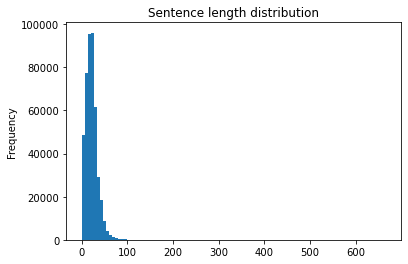

In [11]:
lens = [len(x) for x in train_sentences]
pd.Series(lens).plot.hist(bins=100)
plt.title("First 1000 word distribution")
plt.title("Sentence length distribution")
plt.show()

### Dataset word stats

In [60]:
def dataset_stats(df):
    agg = pd.Series({'uniq_words': len(df),
                     'total_words': df.qty.sum(),
                     'proba_min': df.proba.min(),
                     'proba_max': df.proba.max(),
                     'proba_sum': df.proba.sum(),
                     'max_count': df.qty.max(),
                     'min_count': df.qty.min()})
    return agg
pd.concat([dataset_stats(df_words).rename('all').to_frame().transpose(),
           df_words.groupby('freq_class').apply(dataset_stats)], axis=0)

,uniq_words,total_words,proba_min,proba_max,proba_sum,max_count,min_count
all,176733.0,9492148.0,1.053502e-07,7.247643e-02,1.000000,687957.0,1.0
top-10,10.0,2328845.0,7.905692e-03,7.247643e-02,0.245344,687957.0,75042.0
top-100,100.0,1836657.0,7.072161e-04,7.832684e-03,0.193492,74349.0,6713.0
top-1000,1000.0,2105011.0,1.042967e-04,7.037396e-04,0.221763,6680.0,990.0
top-10000,10000.0,2318738.0,6.847765e-06,1.042967e-04,0.244280,990.0,65.0
top-100000,100000.0,837274.0,1.053502e-07,6.847765e-06,0.088207,65.0,1.0
top-1000000,65623.0,65623.0,1.053502e-07,1.053502e-07,0.006913,1.0,1.0


### Frequencies cluster distribution

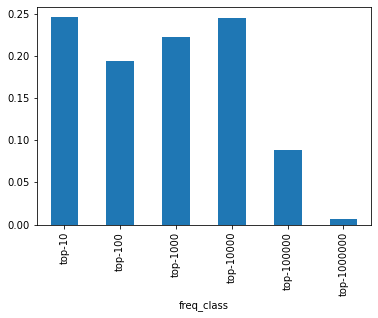

In [13]:
df_words.groupby('freq_class').proba.sum().plot.bar()
plt.show()

### WordSim

In [14]:
def load_ws(ds_root):
    df_ws = pd.read_csv(ds_root/'wordsim353_sim_rel'/'wordsim353_agreed.txt',
                    sep='\t',
                    comment='#',
                    usecols=[1,2,3],
                    names=['word_a',
                           'word_b',
                           'rank'])
    return df_ws

ws = load_ws(EVAL_ROOT)
ws.head()

,word_a,word_b,rank
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


## Training

### Building Vocab

In [15]:
w2v = Word2Vec(alpha=ALPHA,
               min_alpha=MIN_ALPHA,
               workers=cpu_count(),
               vector_size=VECTOR_SIZE,
               window=5,
               min_count=1,
               sg=1,
               negative=5,
               )
w2v.build_vocab(train_sentences, update=False)
idx2word = w2v.wv.index_to_key
word2index = w2v.wv.key_to_index

freq_cats = {cat: []
             for cat in df_words.freq_class.cat.categories}
for i, word in enumerate(idx2word):
    freq_cats[df_words.freq_class.loc[word]].append(i)
freq_cats = {cat: np.array(indices) for cat, indices in freq_cats.items() if len(indices)>0}

### Callbacks

In [16]:
iter_counter = IterCounter()
emb_centroid_callback = CentroidCalculation(context=False)
ctx_centroid_callback = CentroidCalculation(context=True)
emb_centroid_by_freq_callback = CentroidCalculationByCategory(freq_cats, context=False)
ctx_centroid_by_freq_callback = CentroidCalculationByCategory(freq_cats, context=True)

loss_callback = LossCallback()
hparams_callback = HyperParamLogger(iter=lambda _: iter_counter.iter,
                                    epoch=lambda _: (iter_counter.iter/ITER_STEPS) if ITER_STEPS is not None else iter_counter.iter,
                                    alpha=lambda model: model.min_alpha_yet_reached,
                                    loss=lambda _: loss_callback.loss,
                                    loss_p=lambda _: loss_callback.loss_a,
                                    loss_n=lambda _: loss_callback.loss_b,
                                    dist_emb_mean=lambda _: emb_centroid_callback.dist_mean,
                                    dist_emb_std=lambda _: emb_centroid_callback.dist_std,
                                    dist_ctx_mean=lambda _: ctx_centroid_callback.dist_mean,
                                    dist_ctx_std=lambda _: ctx_centroid_callback.dist_std,
                                    corr=lambda model: evaluate_model(model, ws))

callbacks=[iter_counter,
           emb_centroid_callback,
           emb_centroid_by_freq_callback,
           ctx_centroid_callback,
           ctx_centroid_by_freq_callback,
           loss_callback,
           hparams_callback,
           EpochLogger()]

### Vectors initialization

$$
\left\{\begin{matrix}
W_{i,j}  & \sim & \mathcal{U}\left(-\frac{1}{N}, \frac{1}{N}\right)  \\
C_{i,j}  & = & 0
\end{matrix}\right.
$$

In [17]:
def show_weight_distribution(w2v):
    fig, axs = plt.subplots(figsize=(15,8), ncols=2, nrows=2)
    plt.suptitle("Weight distribution")
    axs[0][0].set_title('Word')
    axs[0][0].hist(w2v.wv.vectors.flatten(), bins=300)
    axs[0][0].set_ylabel('Frequency')
    axs[0][0].set_xlabel('Weight')
    axs[0][1].set_title('Context')
    axs[0][1].hist(w2v.syn1neg.flatten(), bins=300)
    axs[0][1].set_xlabel('Weight')

    order = np.argsort(w2v.wv.vectors.mean(axis=0))
    axs[1][0].errorbar(np.arange(w2v.vector_size), w2v.wv.vectors.mean(axis=0)[order], w2v.wv.vectors.std(axis=0)[order])
    axs[1][0].set_ylabel('Mean weight')
    axs[1][0].set_xlabel('Component')
    axs[1][1].errorbar(np.arange(w2v.vector_size), w2v.syn1neg.mean(axis=0)[order], w2v.syn1neg.std(axis=0)[order])
    #axs[0][0].set_ylabel('Mean weight')
    axs[1][1].set_xlabel('Component')

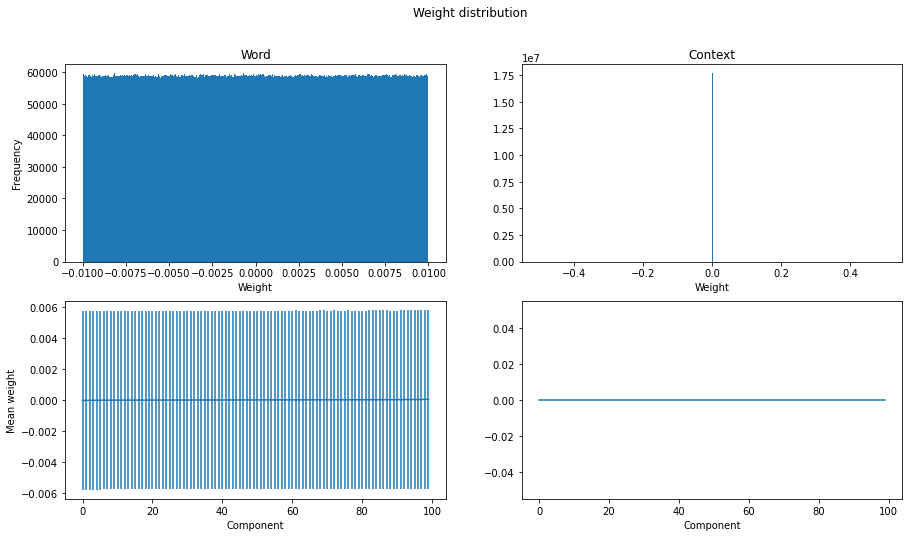

In [18]:
show_weight_distribution(w2v)
plt.show()

### Fitting the model

In [19]:
if ITER_STEPS != 1:
    train_sentences = BatchedCorpus(train_sentences, batch_size=int(math.ceil(len(train_sentences)/ITER_STEPS)))
w2v.train(corpus_iterable=train_sentences,
          total_examples=len(train_sentences),
          callbacks=callbacks,
          compute_loss=True,
          epochs=EPOCHS * ITER_STEPS)

  0%|          | 0/100 [00:00<?, ?iter/s]

(740143841, 949214800)

In [20]:
w2v.save(str(MODEL_ROOT/MODEL_NAME))

### Testing model

In [21]:
test_words = [
    'money',     'psychology',  'tiger',    'cup',    'stock',   'planet', 'car',
    'precedent', 'drink',       'peace',    'food',   'news',   'game',   'doctor',
    'life',      'dollar',      'computer', 'street', 'movie'
]

df_test_result = pd.DataFrame.from_records([
    {'word': word, 'sim_word': sim_word, 'similarity': round(sim, 2), 'rank': rank}
    for word in test_words
    for rank, (sim_word, sim) in enumerate(w2v.wv.most_similar(word))
]).set_index(['word', 'rank']).unstack(level=1)
df_test_result.columns = df_test_result.columns.swaplevel()
df_test_result.sort_index(axis=1, level=0, inplace=True)


## Experiments results

### Final Weigth distribution

In [103]:
def show_weight_distribution_by_class(w2v, freq_cats, bins=300):
    fig, axs = plt.subplots(figsize=(15,8), ncols=2, nrows=2)
    plt.suptitle("Weight distribution - By Frequency")
    axs[0][0].set_title('Word')
    axs[0][0].set_ylabel('Frequency')
    axs[0][0].set_xlabel('Weight')
    axs[0][1].set_title('Context')
    axs[0][1].set_xlabel('Weight')
    axs[1][0].set_ylabel('Mean weight')
    axs[1][0].set_xlabel('Component')
    axs[1][1].set_xlabel('Component')
    for cat_name, indices in freq_cats:
        embedding = w2v.wv.vectors[indices]
        context = w2v.syn1neg[indices]
        weights = np.ones(embedding.size)/float(embedding.size)
        axs[0][0].hist(embedding.flatten(),
                       bins=bins,
                       alpha=0.5,
                       label=cat_name,
                       density=True)
        axs[0][0].legend()
        axs[0][1].hist(context.flatten(),
                       bins=bins,
                       alpha=0.5,
                       label=cat_name,
                       density=True)
        axs[0][1].legend()
        
        order = np.argsort(embedding.mean(axis=0))
        axs[1][0].errorbar(np.arange(w2v.vector_size), embedding.mean(axis=0)[order], embedding.std(axis=0)[order], label=cat_name)
        axs[1][0].legend()
        axs[1][1].errorbar(np.arange(w2v.vector_size), context.mean(axis=0)[order], context.std(axis=0)[order], label=cat_name)
        axs[1][1].legend()
    #plt.legend()
    plt.show()

#### Overall

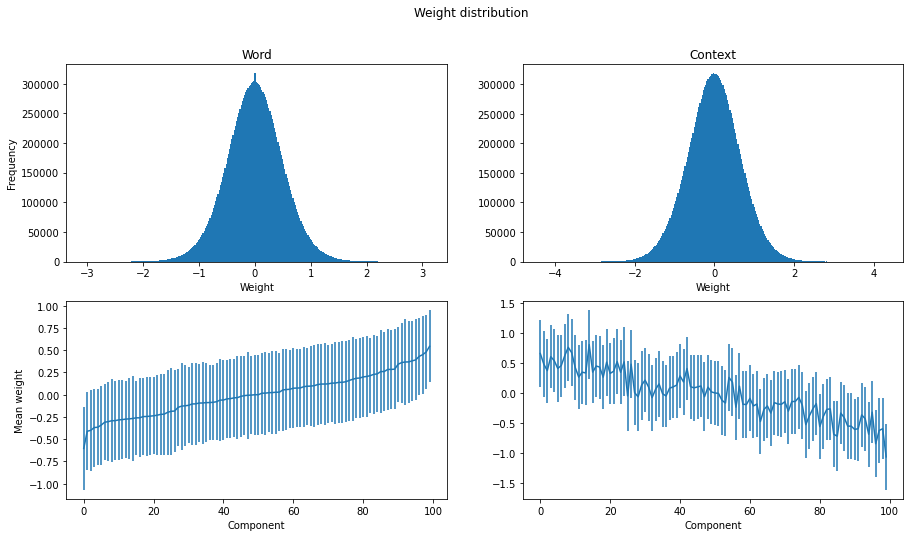

In [23]:
show_weight_distribution(w2v)
plt.show()

#### By Frequency

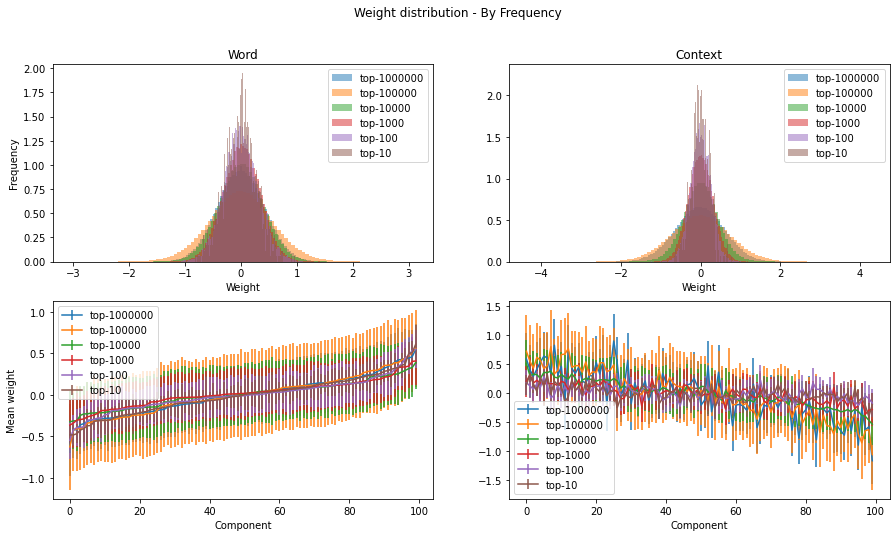

In [104]:
show_weight_distribution_by_class(w2v, reversed(freq_cats.items()), bins=100)
plt.show()

### Losses

In [25]:
params_hist = pd.DataFrame.from_records(hparams_callback._params_hist)

In [26]:
params_hist = params_hist.set_index('iter')

In [27]:
EPOCH_MULTIPLIER = 10
def add_epochs_xticks(ax):
    ax.set_xticks(params_hist.index[0::EPOCH_MULTIPLIER*ITER_STEPS]-1)
    ax.set_xticklabels(params_hist.epoch[0::EPOCH_MULTIPLIER*ITER_STEPS].astype(int))
    
def iter2epoch(i):
    return int(params_hist.iloc[i-1].epoch) if i>0 else 0

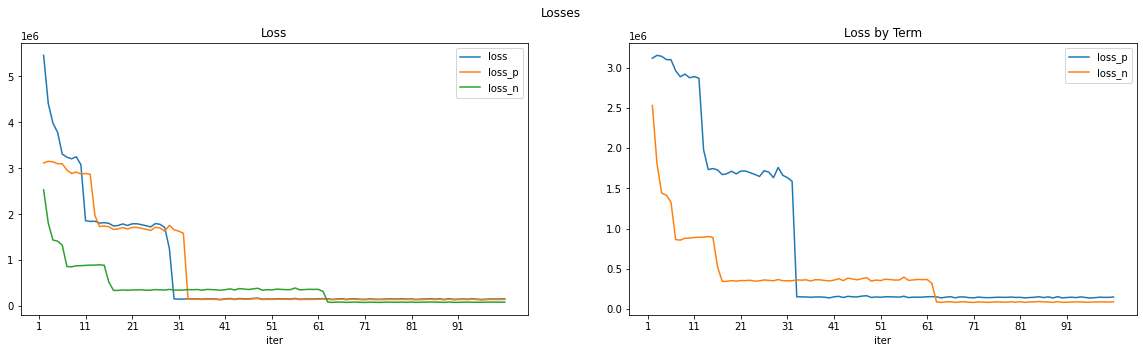

In [28]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=2)
plt.suptitle("Losses")
params_hist[['loss', 'loss_p', 'loss_n']].plot(ax=axs[0], title='Loss')
(params_hist[['loss_p', 'loss_n']]).plot(ax=axs[1], title='Loss by Term')
for ax in axs:
    add_epochs_xticks(ax)
plt.legend()
plt.show()

### WordSim metric

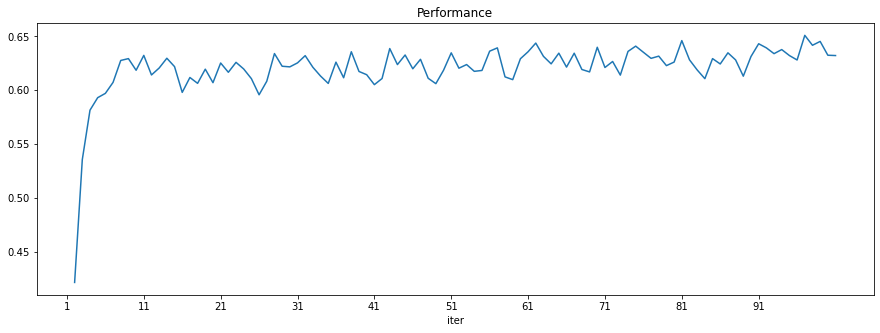

In [29]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
params_hist['corr'].plot(title='Performance', ax=ax)
add_epochs_xticks(ax)
plt.show()

### Average norm

In [30]:
def plot_stats_by_epoch(ax, dist_means, dist_stds, label=None, alpha=0.5):
    #ax.errorbar(
    #    x=np.arange(len(dist_means)),
    #    y=np.array(dist_means),
    #    yerr=np.array(dist_stds),
    #    label=label,
    #    alpha=alpha,
    #)
    
    ax.plot(np.arange(len(dist_means)),
            np.array(dist_means),
            alpha=alpha,
            #label=label
    )
    ax.fill_between(
        x=np.arange(len(dist_means)),
        y1=np.array(dist_means) + np.array(dist_stds),
        y2=np.array(dist_means) - np.array(dist_stds),
        label=label,
        alpha=alpha,
    )

#### Overall

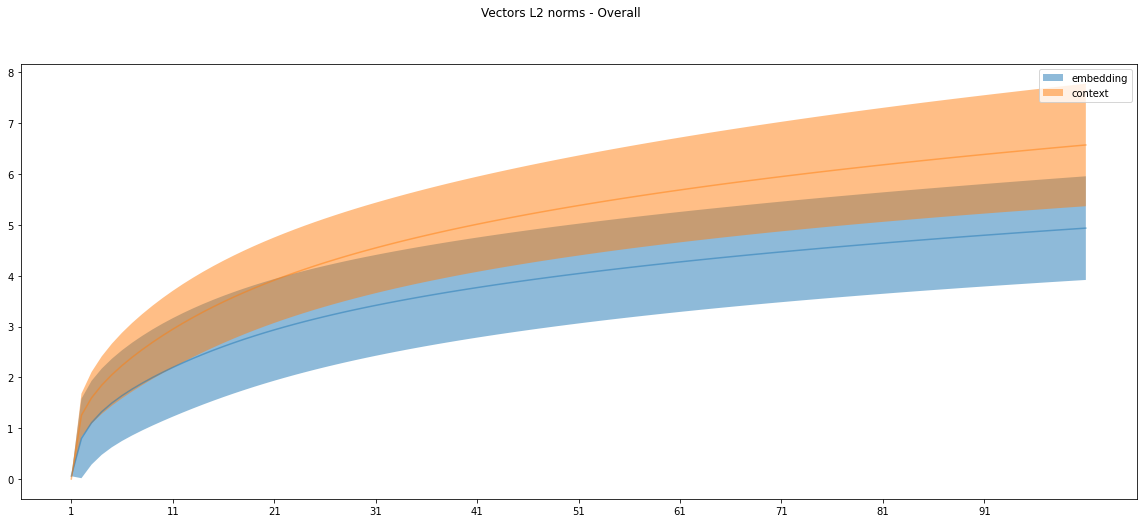

In [31]:
fig = plt.figure(figsize=(20, 8))
plt.suptitle("Vectors L2 norms - Overall")
ax = fig.gca()
plot_stats_by_epoch(ax,
                    emb_centroid_callback._norm_means,
                    emb_centroid_callback._norm_stds,
                    label='embedding')
plot_stats_by_epoch(ax,
                    ctx_centroid_callback._norm_means,
                    ctx_centroid_callback._norm_stds,
                    label='context')
add_epochs_xticks(ax)

plt.legend()
plt.show()

#### By frequency

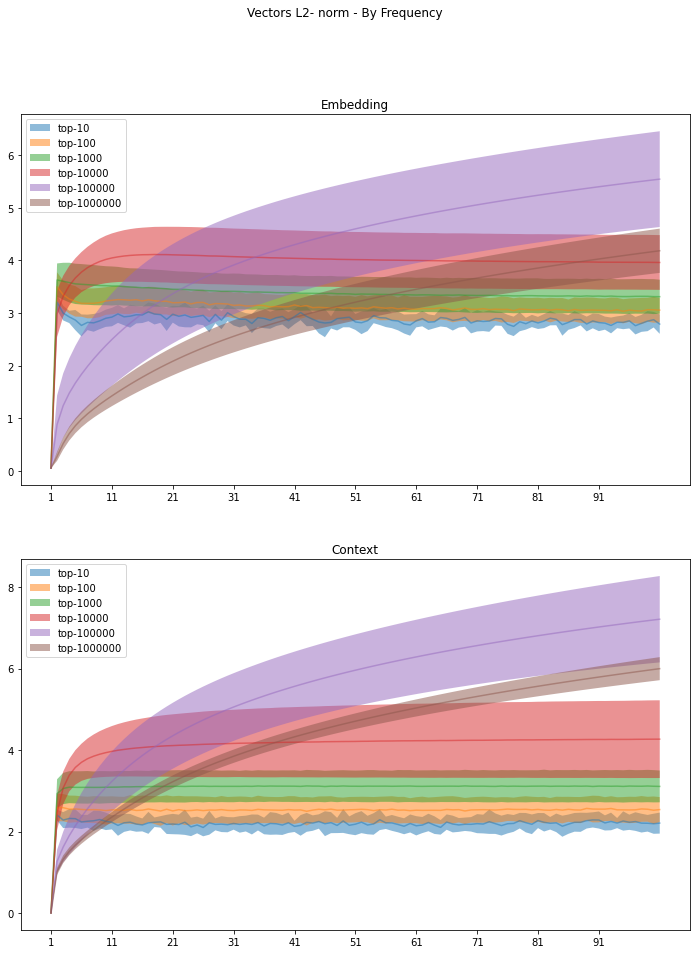

In [32]:
fig, axs = plt.subplots(figsize=(12, 15), nrows=2)
plt.suptitle("Vectors L2- norm - By Frequency")
dist_emb_means_by_freq = emb_centroid_by_freq_callback.norm_means
dist_emb_stds_by_freq = emb_centroid_by_freq_callback.norm_stds

dist_ctx_means_by_freq = ctx_centroid_by_freq_callback.norm_means
dist_ctx_stds_by_freq = ctx_centroid_by_freq_callback.norm_stds

axs[0].set_title("Embedding")
axs[1].set_title("Context")

for cat in emb_centroid_by_freq_callback.centroids.keys():
    plot_stats_by_epoch(axs[0],
                        dist_emb_means_by_freq[cat],
                        dist_emb_stds_by_freq[cat],
                        label=cat)
    plot_stats_by_epoch(axs[1],
                        dist_ctx_means_by_freq[cat],
                        dist_ctx_stds_by_freq[cat],
                        label=cat)
for ax in axs:
    add_epochs_xticks(ax)
    ax.legend()
plt.show()

### Centroid shift

In [33]:
unit = 'iters' if ITER_STEPS != 1 else 'epoch'

In [34]:
def show_centroid_shift(axs, centroids, epoch_split=3, label=None, unit='epoch'):
    epochs = centroids.shape[0]-1
    shift_norm_centroid_hist = rowise_distance(centroids[1:],centroids[:-1])
    shift_sim_centroid_hist = rowise_cosine_sim(centroids[1:],centroids[:-1])
    
    axs[0][0].set_title(f"First {epoch_split} {unit}")
    axs[0][0].set_ylabel("Distance")
    axs[0][0].plot(range(1,epoch_split+1),shift_norm_centroid_hist[:epoch_split], label=label)
    axs[0][1].set_ylabel("Distance")
    axs[0][1].set_title(f"Last {epochs-epoch_split} {unit}")
    axs[0][1].plot(range(epoch_split+1,epochs+1),shift_norm_centroid_hist[epoch_split:], label=label)
    axs[0][2].set_title(f"All")
    axs[0][2].set_ylabel("Distance")
    axs[0][2].plot(range(1,epochs+1),shift_norm_centroid_hist, label=label)
    

    axs[1][0].set_title(f"First {epoch_split} {unit}")
    axs[1][0].set_ylabel("Similarity")
    axs[1][0].plot(range(1,epoch_split+1),shift_sim_centroid_hist[:epoch_split], label=label)
    axs[1][1].set_ylabel("Similarity")
    axs[1][1].set_title(f"Last {epochs-epoch_split} {unit}")
    axs[1][1].plot(range(epoch_split+1,epochs+1),shift_sim_centroid_hist[epoch_split:], label=label)
    axs[1][2].set_title(f"All")
    axs[1][2].set_ylabel("Similarity")
    axs[1][2].plot(range(1,epochs+1),shift_sim_centroid_hist, label=label)

Medida de que tan se aleja (en distancia $L^2$ y ánglulo) el centroide al terminar una epocá con respecto al centroide de la epoca anterior

#### Overall

/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)


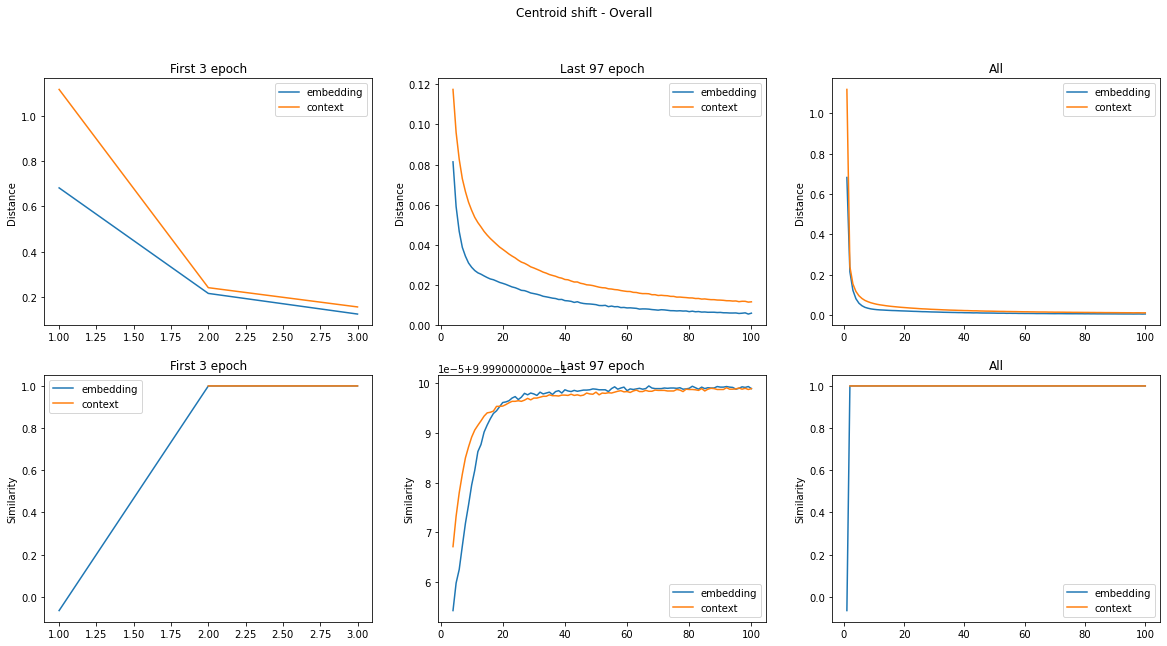

In [35]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)

plt.suptitle("Centroid shift - Overall")

show_centroid_shift(axs, emb_centroid_callback.centroids, label='embedding', epoch_split=3*ITER_STEPS, unit=unit)
show_centroid_shift(axs, ctx_centroid_callback.centroids, label='context', epoch_split=3*ITER_STEPS, unit=unit)
for ax in axs.flatten():
    ax.legend()
plt.show()

#### By frequency

##### Embedding

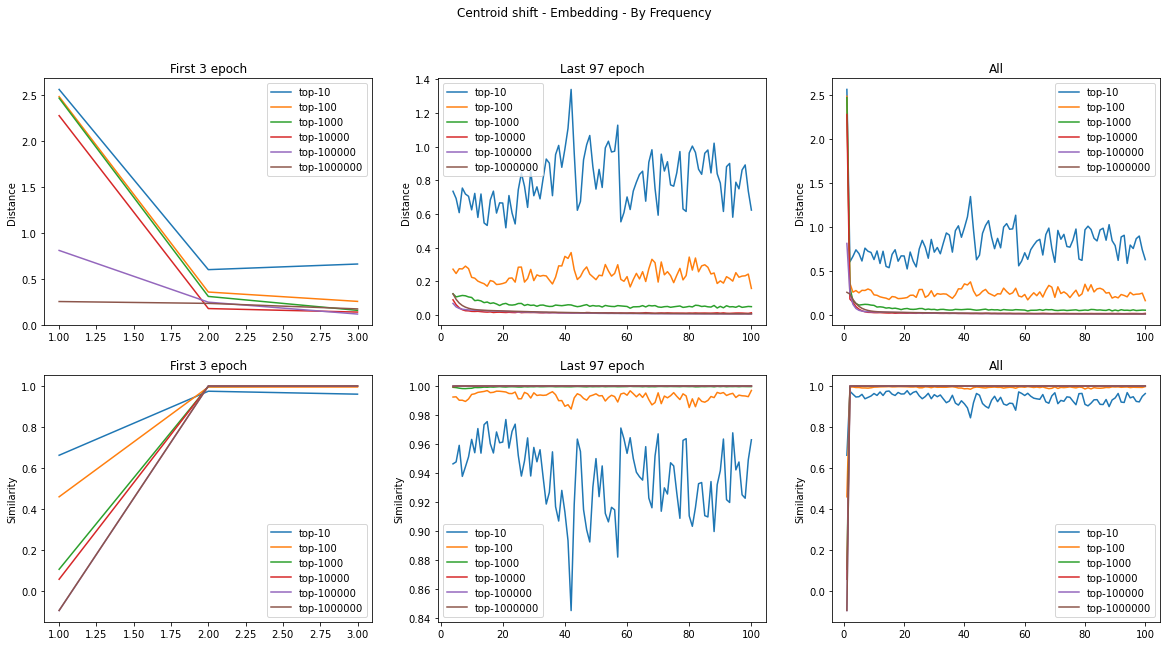

In [36]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
plt.suptitle("Centroid shift - Embedding - By Frequency")

for cat, centroid_hist in emb_centroid_by_freq_callback.centroids.items():
    show_centroid_shift(axs, centroid_hist, label=cat, epoch_split=3*ITER_STEPS, unit=unit)
for ax in axs.flatten():
    ax.legend()
plt.show()

##### Context

/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)


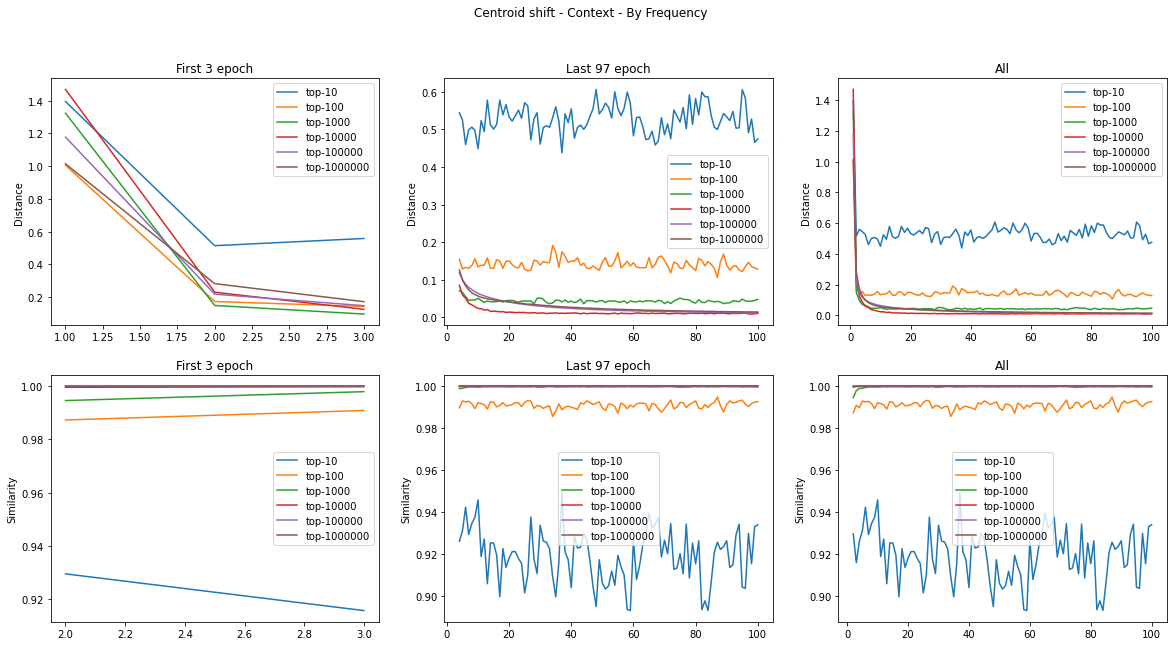

In [37]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
plt.suptitle("Centroid shift - Context - By Frequency")

for cat, centroid_hist in ctx_centroid_by_freq_callback.centroids.items():
    show_centroid_shift(axs, centroid_hist, label=cat, epoch_split=3*ITER_STEPS, unit=unit)
for ax in axs.flatten():
    ax.legend()
plt.show()

### Multidimensional Scaling

#### Overall

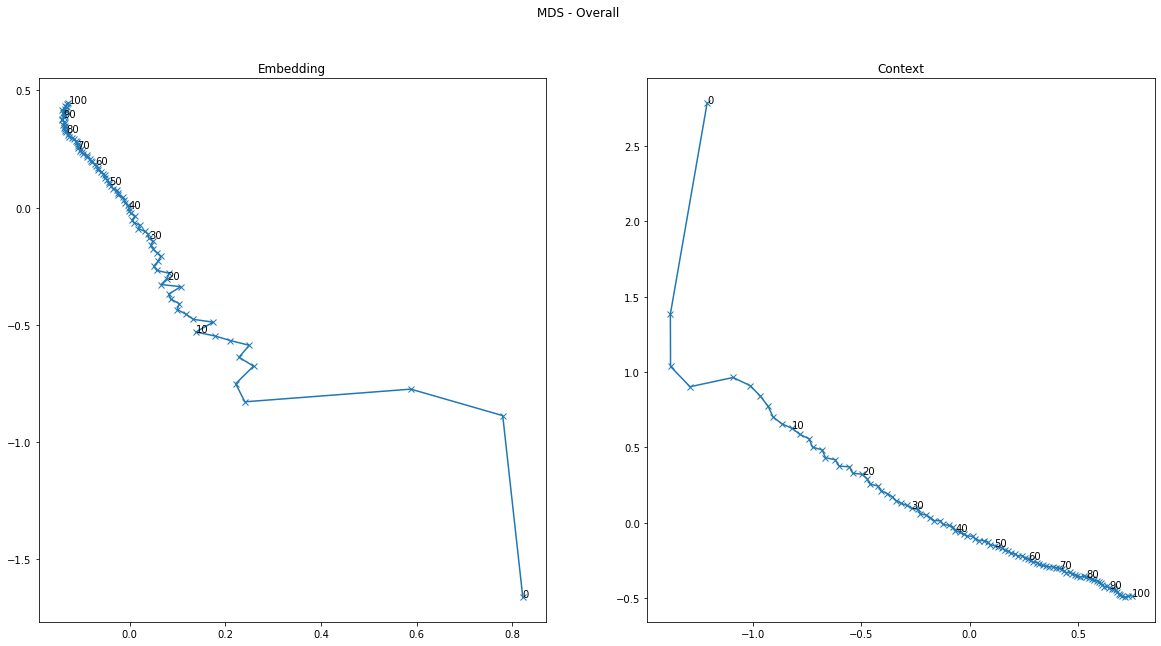

In [38]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

plt.suptitle("MDS - Overall")

emb_mds = MDS(n_components=2).fit_transform(emb_centroid_callback.centroids)
ctx_mds = MDS(n_components=2).fit_transform(ctx_centroid_callback.centroids)

axs[0].set_title("Embedding")
axs[0].plot(emb_mds[:,0], emb_mds[:,1], marker='x')
axs[1].set_title("Context")
axs[1].plot(ctx_mds[:,0], ctx_mds[:,1], marker='x')

for i in range(0, emb_mds.shape[0], EPOCH_MULTIPLIER * ITER_STEPS):
    axs[0].text(emb_mds[i,0],
                emb_mds[i,1],
                str(iter2epoch(i)))
    axs[1].text(ctx_mds[i,0],
                ctx_mds[i,1],
                str(iter2epoch(i)))
plt.show()

#### By Frequency

In [39]:
def get_embeddings_cats(embs_by_cat):
    cats, emb_matrix = [], []
    for cat, embs in embs_by_cat.items():
        cats.extend([cat] * len(embs))
        emb_matrix.extend(embs)
    return np.array(cats), np.stack(emb_matrix)

In [ ]:
embs_cats, emb_X = get_embeddings_cats(emb_centroid_by_freq_callback.centroids)
ctx_cats, ctx_X = get_embeddings_cats(ctx_centroid_by_freq_callback.centroids)
emb_mds = MDS(n_components=2, n_jobs=cpu_count()).fit_transform(emb_X)
ctx_mds = MDS(n_components=2, n_jobs=cpu_count()).fit_transform(ctx_X)

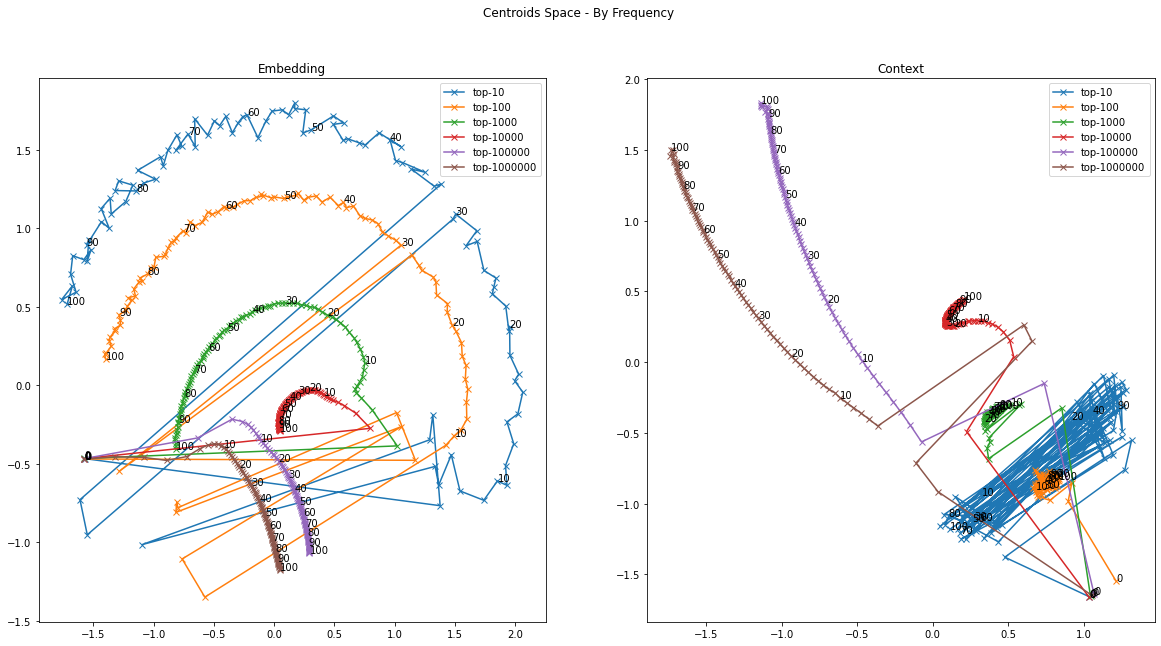

In [51]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

plt.suptitle("Centroids Space - By Frequency")

axs[0].set_title("Embedding")
axs[1].set_title("Context")

for cat in emb_centroid_by_freq_callback.centroids:
    emb_centroids_projected = emb_mds[np.argwhere(embs_cats == cat).squeeze()]
    ctx_centroids_projected = ctx_mds[np.argwhere(ctx_cats == cat).squeeze()]

    
    axs[0].plot(emb_centroids_projected[:,0], emb_centroids_projected[:,1], marker='x', label=cat)
    axs[1].plot(ctx_centroids_projected[:,0], ctx_centroids_projected[:,1], marker='x', label=cat)

    for i in range(0, emb_centroids_projected.shape[0], EPOCH_MULTIPLIER * ITER_STEPS):
        axs[0].text(emb_centroids_projected[i,0],
                    emb_centroids_projected[i,1],
                    str(iter2epoch(i)))
        axs[1].text(ctx_centroids_projected[i,0],
                    ctx_centroids_projected[i,1],
                    str(iter2epoch(i)))
axs[0].legend()
axs[1].legend()

plt.show()

### Centroids Space

Proyección PCA del historial de centroides en el espacio de embeddings

In [42]:
pca_emb=PCA(n_components=2).fit(w2v.wv.vectors)
pca_ctx=PCA(n_components=2).fit(w2v.syn1neg)

#### By Frequency

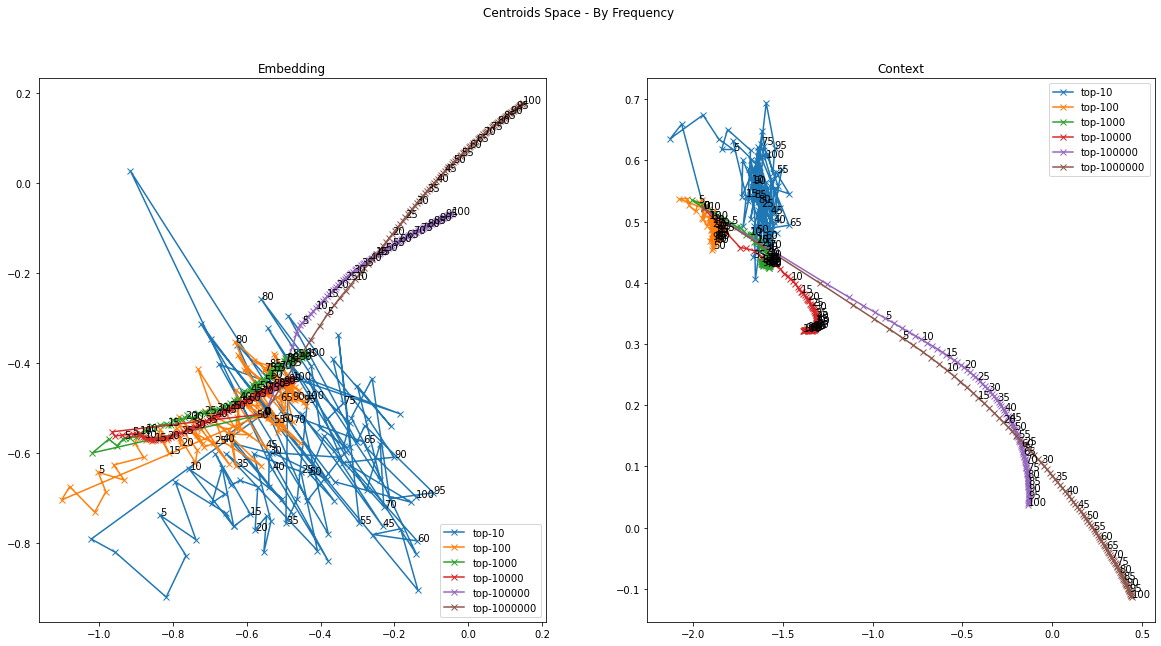

In [43]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

plt.suptitle("Centroids Space - By Frequency")

emb_centroids_by_cat = emb_centroid_by_freq_callback.centroids
ctx_centroids_by_cat = ctx_centroid_by_freq_callback.centroids

axs[0].set_title("Embedding")
axs[1].set_title("Context")

for cat in emb_centroid_by_freq_callback.centroids:
    emb_centroids_projected = pca_emb.transform(emb_centroids_by_cat[cat])
    ctx_centroids_projected = pca_ctx.transform(ctx_centroids_by_cat[cat])

    
    axs[0].plot(emb_centroids_projected[:,0], emb_centroids_projected[:,1], marker='x', label=cat)
    axs[1].plot(ctx_centroids_projected[:,0], ctx_centroids_projected[:,1], marker='x', label=cat)

    for i in range(0, emb_centroids_projected.shape[0], 5):
        axs[0].text(emb_centroids_projected[i,0],
                    emb_centroids_projected[i,1],
                    str(iter2epoch(i)))
        axs[1].text(ctx_centroids_projected[i,0],
                    ctx_centroids_projected[i,1],
                    str(iter2epoch(i)))
axs[0].legend()
axs[1].legend()

plt.show()

#### Overall

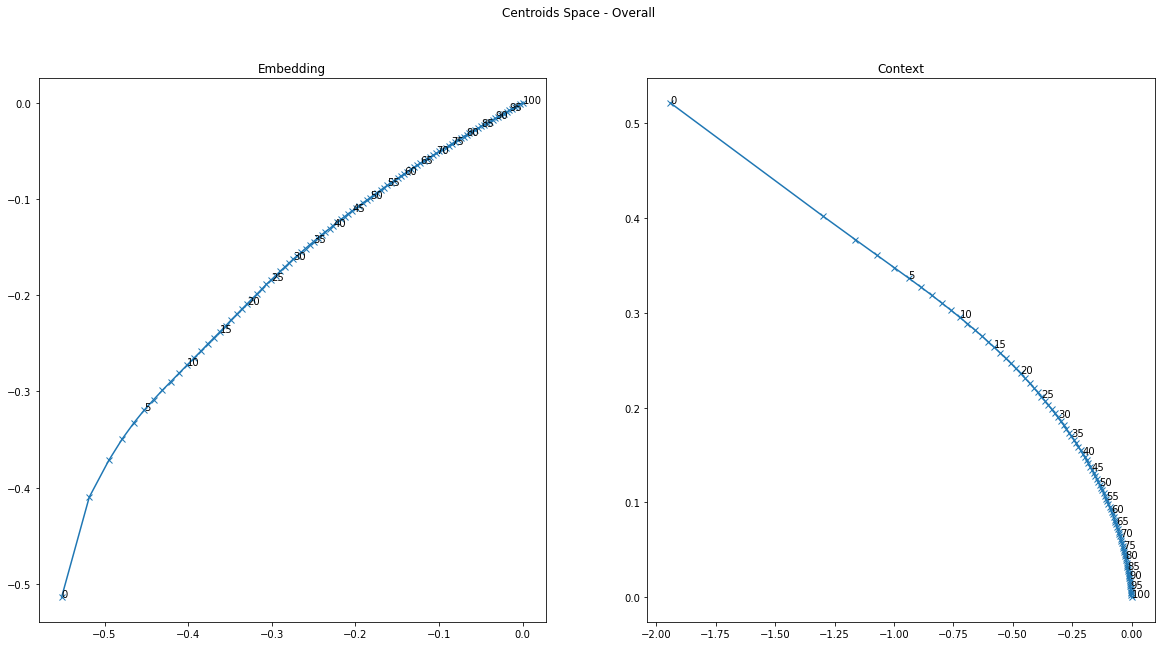

In [44]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

plt.suptitle("Centroids Space - Overall")

emb_centroids_projected = pca_emb.transform(emb_centroid_callback.centroids)
ctx_centroids_projected = pca_ctx.transform(ctx_centroid_callback.centroids)

axs[0].set_title("Embedding")
axs[0].plot(emb_centroids_projected[:,0], emb_centroids_projected[:,1], marker='x')
axs[1].set_title("Context")
axs[1].plot(ctx_centroids_projected[:,0], ctx_centroids_projected[:,1], marker='x')

for i in range(0, emb_centroids_projected.shape[0], 5):
    axs[0].text(emb_centroids_projected[i,0],
                emb_centroids_projected[i,1],
                str(iter2epoch(i)))
    axs[1].text(ctx_centroids_projected[i,0],
                ctx_centroids_projected[i,1],
                str(iter2epoch(i)))
plt.show()

### Distance to centroid

#### Overall

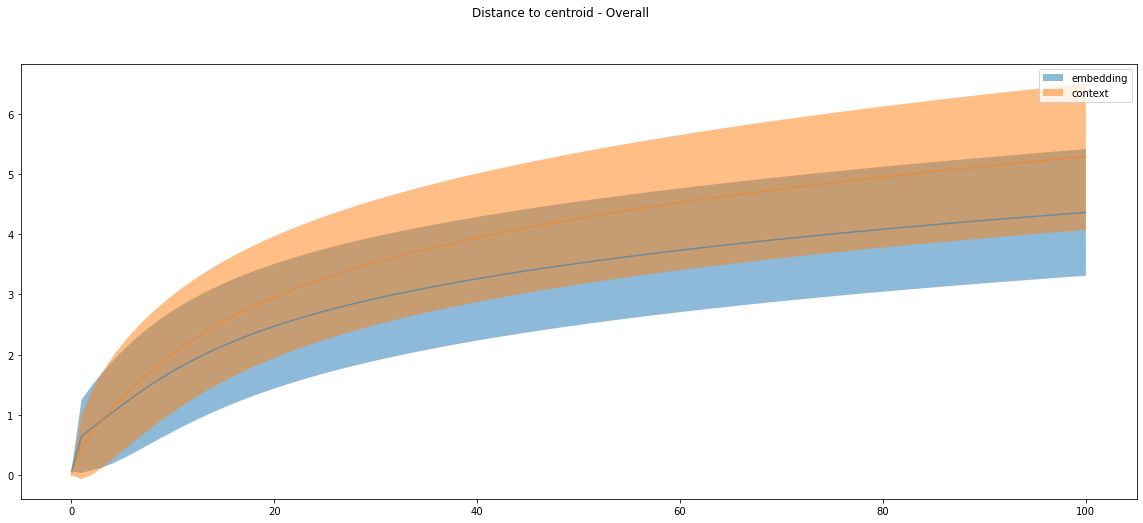

In [45]:
fig = plt.figure(figsize=(20, 8))
plt.suptitle("Distance to centroid - Overall")
ax = fig.gca()
plot_stats_by_epoch(ax,
                    emb_centroid_callback._dist_means,
                    emb_centroid_callback._dist_stds,
                    label='embedding')
plot_stats_by_epoch(ax,
                    ctx_centroid_callback._dist_means,
                    ctx_centroid_callback._dist_stds,
                    label='context')
plt.legend()
plt.show()

#### By Frequency

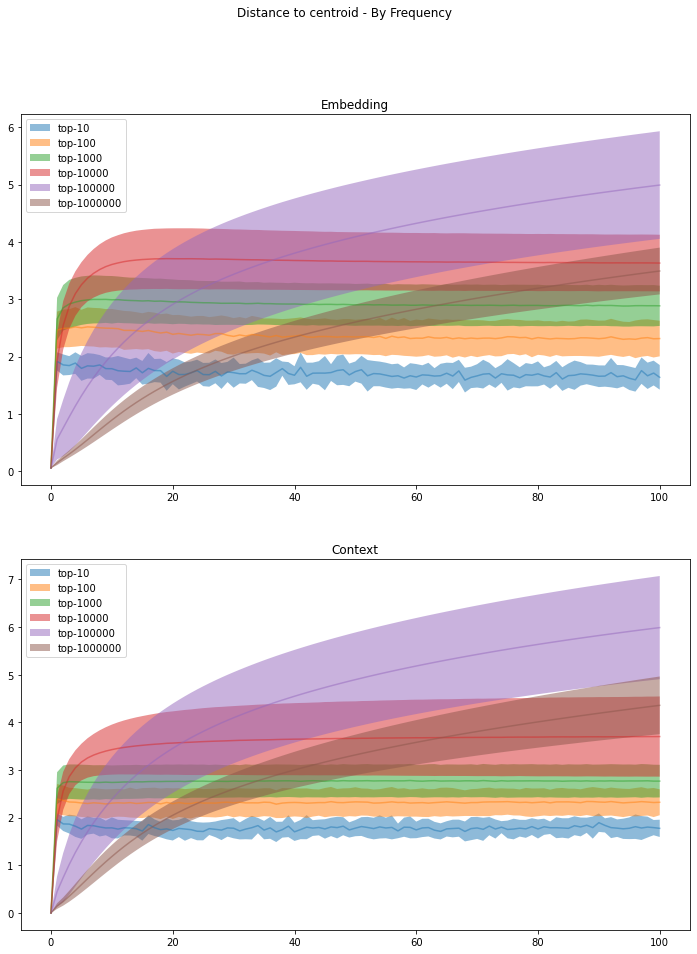

In [46]:
fig, axs = plt.subplots(figsize=(12, 15), nrows=2)
plt.suptitle("Distance to centroid - By Frequency")
dist_emb_means_by_freq = emb_centroid_by_freq_callback.dist_means
dist_emb_stds_by_freq = emb_centroid_by_freq_callback.dist_stds

dist_ctx_means_by_freq = ctx_centroid_by_freq_callback.dist_means
dist_ctx_stds_by_freq = ctx_centroid_by_freq_callback.dist_stds

axs[0].set_title("Embedding")
axs[1].set_title("Context")

for cat in emb_centroid_by_freq_callback.centroids.keys():
    plot_stats_by_epoch(axs[0],
                        dist_emb_means_by_freq[cat],
                        dist_emb_stds_by_freq[cat],
                        label=cat)
    plot_stats_by_epoch(axs[1],
                        dist_ctx_means_by_freq[cat],
                        dist_ctx_stds_by_freq[cat],
                        label=cat)
for ax in axs:
    ax.legend()
plt.show()

### Distance from embedding centroid to context centroid

#### Overall

/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


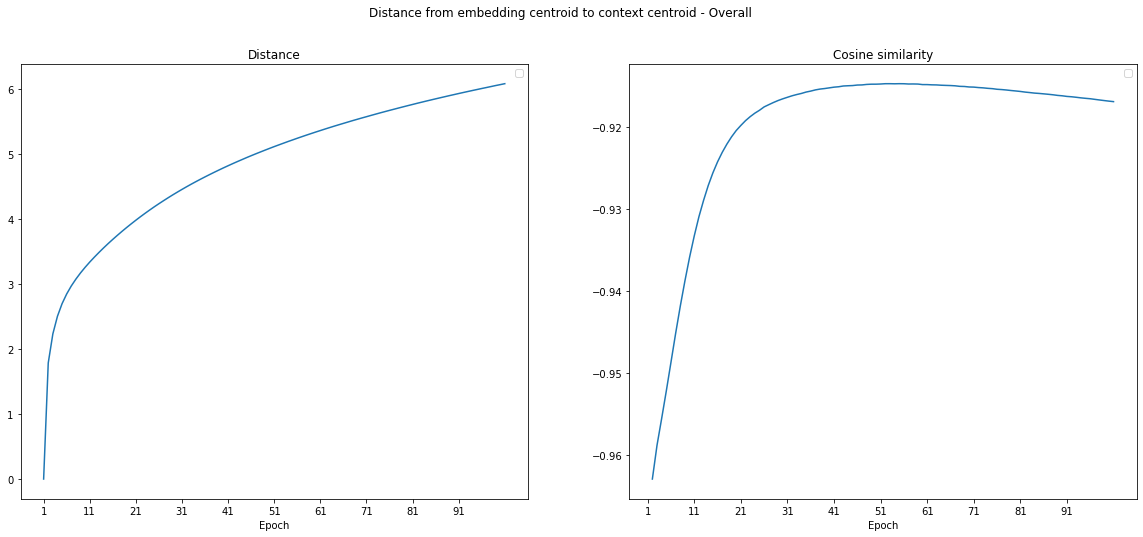

In [53]:
fig, axs = plt.subplots(figsize=(20, 8), ncols=2)
plt.suptitle("Distance from embedding centroid to context centroid - Overall")
axs[0].set_title("Distance")
axs[0].plot(rowise_distance(emb_centroid_callback.centroids, ctx_centroid_callback.centroids))
axs[0].set_xlabel("Epoch")
axs[1].set_title("Cosine similarity")
axs[1].plot(rowise_cosine_sim(emb_centroid_callback.centroids, ctx_centroid_callback.centroids))
axs[1].set_xlabel("Epoch")

for ax in axs:
    ax.legend()
    add_epochs_xticks(ax)
plt.show()

#### By Frequency

/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)
/home/chino/Proyectos/tesis/thesis/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  return dot / (norm_a * norm_b)


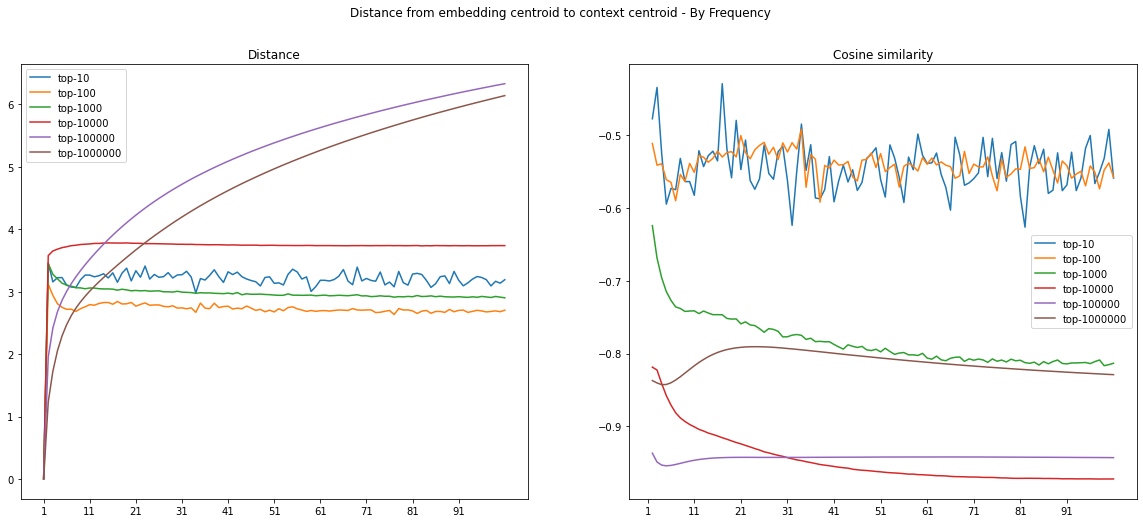

In [52]:
fig, axs = plt.subplots(figsize=(20, 8), ncols=2)

emb_centroids_by_cat = emb_centroid_by_freq_callback.centroids
ctx_centroids_by_cat = ctx_centroid_by_freq_callback.centroids

plt.suptitle("Distance from embedding centroid to context centroid - By Frequency")

axs[0].set_title("Distance")
axs[1].set_title("Cosine similarity")

for cat in emb_centroid_by_freq_callback.centroids:
    axs[0].plot(rowise_distance(emb_centroids_by_cat[cat], ctx_centroids_by_cat[cat]), label=cat)
    axs[1].plot(rowise_cosine_sim(emb_centroids_by_cat[cat], ctx_centroids_by_cat[cat]), label=cat)
    
for ax in axs:
    ax.legend()
    add_epochs_xticks(ax)
plt.show()

### Similarity between frequency classes

In [49]:
from utils import pairwise_cosine_sim

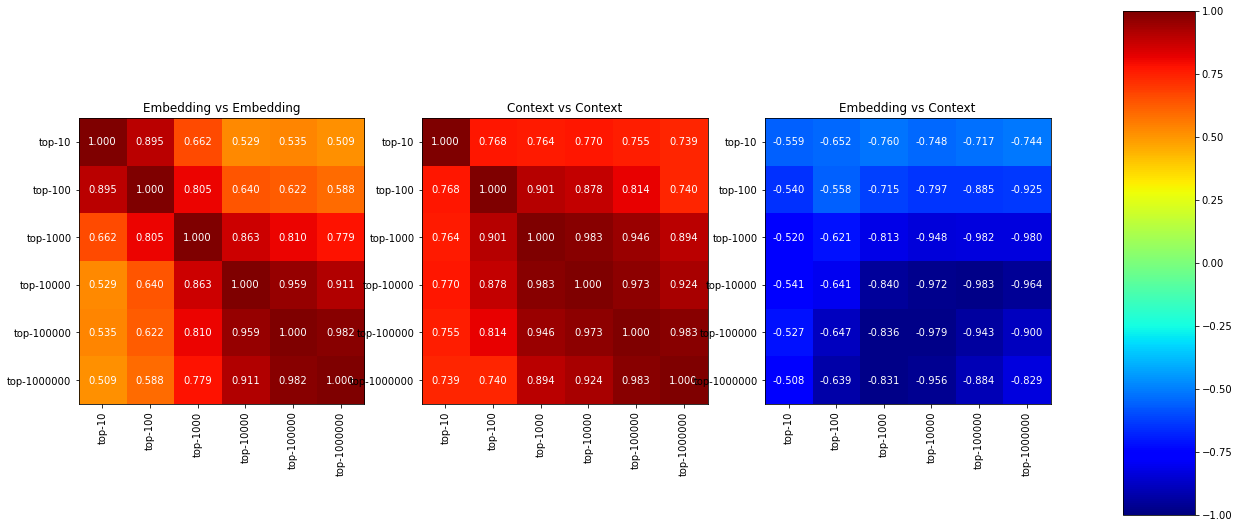

In [50]:
def show_sim_heatmap(ax, X, Y, classes, cmap='jet'):
    X = np.stack(list(X))
    Y = np.stack(list(Y))
    classes = list(classes)
    sims = pairwise_cosine_sim(X, Y)
    im = ax.imshow(sims, vmin=-1, vmax=1, cmap=cmap)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticks(np.arange(len(classes)))
    ax.set_yticklabels(classes)
    for i in range(len(X)):
        for j in range(len(Y)):
            ax.text(i, j, f'{sims[i][j]:.3f}', ha="center", va="center", color="w")
    return im
    

fig, axs = plt.subplots(figsize=(20, 10), ncols=3)
axs[0].set_title("Embedding vs Embedding")
show_sim_heatmap(axs[0], emb_centroid_by_freq_callback.centroid.values(), emb_centroid_by_freq_callback.centroid.values(), emb_centroid_by_freq_callback.centroid.keys())
axs[1].set_title("Context vs Context")
show_sim_heatmap(axs[1], ctx_centroid_by_freq_callback.centroid.values(), ctx_centroid_by_freq_callback.centroid.values(), ctx_centroid_by_freq_callback.centroid.keys())
axs[2].set_title("Embedding vs Context")
im = show_sim_heatmap(axs[2], emb_centroid_by_freq_callback.centroid.values(), ctx_centroid_by_freq_callback.centroid.values(), emb_centroid_by_freq_callback.centroid.keys())
for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()